# Moving Average Filter
A moving average filter is a commonly used digital signal processing technique for smoothing out noisy data or reducing fluctuations in a time series. The filter works by calculating the average value of a series of data points over a sliding window of a fixed size.

For example, a 3-point moving average filter would take the average of the current data point and its two neighboring points to generate a new value. As the window slides along the data series, each point is replaced with its moving average value.

Moving average filters can be used to reduce noise in a signal, eliminate high-frequency variations, and highlight trends and patterns in the data

In [25]:
import pandas as pd


jump = pd.read_csv('allJump.csv')
walk = pd.read_csv('allWalk.csv')
both = pd.read_csv('datasetOverall.csv')

#renaming the columns in the dataset so it is easier to call - column names (time, x,y,z,abs) are the same for all datasets
jump = jump.rename(columns={"Time (s)" : "time", "Linear Acceleration x (m/s^2)" : "x", 
                     "Linear Acceleration y (m/s^2)" : "y", "Linear Acceleration z (m/s^2)" : "z", 
                     "Absolute acceleration (m/s^2)" : "abs"})

walk = walk.rename(columns={"Time (s)" : "time", "Linear Acceleration x (m/s^2)" : "x", 
                     "Linear Acceleration y (m/s^2)" : "y", "Linear Acceleration z (m/s^2)" : "z", 
                     "Absolute acceleration (m/s^2)" : "abs"})

both = both.rename(columns={"Time (s)" : "time", "Linear Acceleration x (m/s^2)" : "x", 
                     "Linear Acceleration y (m/s^2)" : "y", "Linear Acceleration z (m/s^2)" : "z", 
                     "Absolute acceleration (m/s^2)" : "abs"})


window_size = 5 * 100  #Choose an appropriate window size (iphone 11 has 100hz rate so 5 * 100)

# Calculate the moving average for each axis
filtered_xj = jump['x'].rolling(window=window_size, center=True).mean()
filtered_yj = jump['y'].rolling(window=window_size, center=True).mean()
filtered_zj = jump['z'].rolling(window=window_size, center=True).mean()
filtered_absj = jump['abs'].rolling(window=window_size, center=True).mean()

filtered_xw = walk['x'].rolling(window=window_size, center=True).mean()
filtered_yw = walk['y'].rolling(window=window_size, center=True).mean()
filtered_zw = walk['z'].rolling(window=window_size, center=True).mean()
filtered_absw = walk['abs'].rolling(window=window_size, center=True).mean()

# Combine filtered acceleration data with time into a new dataframe
filtered_data_jump = pd.DataFrame({'time': jump['time'], 'x': filtered_xj, 'y': filtered_yj, 'z': filtered_zj, 'abs': filtered_absj, 'method': jump['method']})
filtered_data_jump.dropna(inplace=True)  # Remove rows with NaN values due to the moving average calculation


filtered_data_walk = pd.DataFrame({'time': walk['time'], 'x': filtered_xw, 'y': filtered_yw, 'z': filtered_zw, 'abs': filtered_absw, 'method': walk['method']})
filtered_data_walk.dropna(inplace=True) 

#filtered_data_jump and filtered_data_walk are the datasets that we will use for the machine learning



     time         x         y         z       abs  method
250  2.51  0.059142 -0.221684  0.338061  6.976698       0
251  2.52  0.065652 -0.237270  0.342677  6.992666       0
252  2.53  0.070838 -0.251160  0.345087  7.005126       0
253  2.54  0.073944 -0.263254  0.344287  7.015112       0
254  2.55  0.074576 -0.272948  0.343247  7.021172       0
     time         x         y         z       abs  method
250  2.50  0.038465 -0.124005 -0.050757  1.725114       1
251  2.51  0.031259 -0.124005 -0.055373  1.729094       1
252  2.52  0.023543 -0.124325 -0.061253  1.733294       1
253  2.53  0.015865 -0.125501 -0.067853  1.738074       1
254  2.54  0.008235 -0.127085 -0.074853  1.743034       1


# Feature Extraction

Feature extraction is the process of selecting and transforming relevant information, or "features," from raw data in order to create a new representation that is more meaningful and useful for a specific task

In [26]:
import matplotlib.pyplot as plt

featured = pd.DataFrame(columns = ['max', 'min', 'mean', 'median', 'range', 'std', 'var', 'kurt', 'skew'])

df_abs = filtered_data_jump.iloc[:,4]
max = df_abs.rolling(window= window_size).max()                 
min = df_abs.rolling(window= window_size).min()
mean = df_abs.rolling(window= window_size).mean()
median =df_abs.rolling(window= window_size).median()
range = df_abs.rolling(window= window_size).apply(lambda x: x.max() - x.min())
std = df_abs.rolling(window= window_size).std()
var = df_abs.rolling(window= window_size).var()
kurt = df_abs.rolling(window= window_size).kurt()
skew = df_abs.rolling(window= window_size).skew()

featured['max'] = max                
featured['min'] = min
featured['mean'] = mean
featured['median'] = median
featured['range'] = range
featured['std'] = std
featured['var'] = var
featured['kurt']= kurt
featured['skew'] = skew

featured.dropna(inplace=True)
featured.to_csv('jumpingFeatures.csv', index=False)


#---------------------------------------------
#Feature EXtraction for walking Below
#---------------------------------------------

featured2 = pd.DataFrame(columns = ['max', 'min', 'mean', 'median', 'range', 'std', 'var', 'kurt', 'skew'])

df_abs = filtered_data_walk.iloc[:,4]
max = df_abs.rolling(window= window_size).max()                 
min = df_abs.rolling(window= window_size).min()
mean = df_abs.rolling(window= window_size).mean()
median =df_abs.rolling(window= window_size).median()
range = df_abs.rolling(window= window_size).apply(lambda x: x.max() - x.min())
std = df_abs.rolling(window= window_size).std()
var = df_abs.rolling(window= window_size).var()
kurt = df_abs.rolling(window= window_size).kurt()
skew = df_abs.rolling(window= window_size).skew()

featured2['max'] = max                
featured2['min'] = min
featured2['mean'] = mean
featured2['median'] = median
featured2['range'] = range
featured2['std'] = std
featured2['var'] = var
featured2['kurt']= kurt
featured2['skew'] = skew

featured2.dropna(inplace=True)
featured2.to_csv('walkingFeatures.csv', index=False)


#---------------------------------------------
#Now combine the datasets for training and testing below and normalize the data
#---------------------------------------------

from sklearn.preprocessing import MinMaxScaler


result = pd.concat([filtered_data_jump, filtered_data_walk])

#normalize the data

columns_to_normalize = ['time','x' ,'y','z','abs']
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(result[columns_to_normalize])
result[columns_to_normalize] = normalized_data

result.to_csv('finalCombined.csv', index=False)


# CLassifier Below


Accuracy: 91.68%


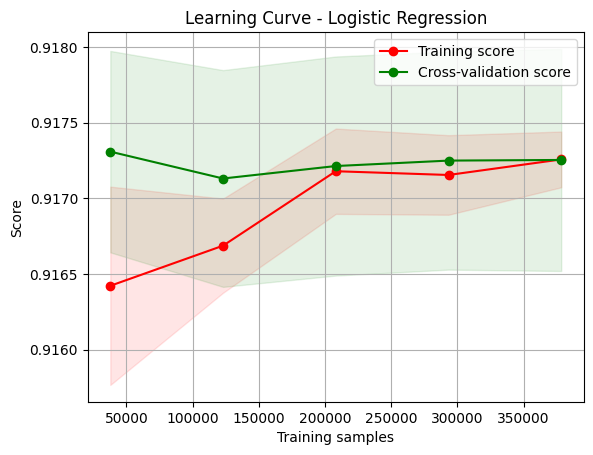

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training samples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

X = result.drop("method", axis=1)   # Creates new dataframe with all columns except method
y = result["method"]                # Creates new dataframe with only the method column

# Splits X (the features) and y (the labels/answers) into training and testing sets (90% training, 10% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

scaler = StandardScaler()
logreg = LogisticRegression(max_iter=10000)
clf = make_pipeline(scaler, logreg)

# This line fits the machine learning algorithm clf to the training data X_train and y_train. 
# The algorithm learns to map the input features in X_train to the output labels in y_train
clf.fit(X_train, y_train)

# The trained clf algorithm predicts the labels of the test data X_test. The predicted labels are stored in y_pred.
y_pred = clf.predict(X_test)

# The accuracy_score function compares the predicted labels y_pred to the actual labels y_test and returns the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot the learning curve
plot_learning_curve(clf, 'Learning Curve - Logistic Regression', X_train, y_train, cv=5)
